# Figure 2b (Public good game)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from tqdm import tqdm
from numba import njit

## Helper functions

In [27]:
def get_strategies(n):
    """Generate all strategies (binary representation)"""
    num_strategies = 2**(2*n)
    indices = np.arange(num_strategies)
    # Generate strategy matrix: (Strategies x Bits)
    strategies = ((indices[:, None] & (1 << np.arange(2*n)[::-1])) > 0).astype(int)
    return strategies

def calc_binom(N, n):
    """
    Precompute Hypergeometric/Binomial distribution probabilities.
    bm[row, col] represents the probability of selecting n-1 neighbors 
    containing 'col' mutants from a population of N-1 individuals 
    that has 'row' total mutants.
    
    Note: Python indexing starts at 0, so adjustments are made for storage.
    """
    # N rows (corresponding to 0..N-1 mutants in the population)
    # n+1 columns (corresponding to 0..n mutants in the sample/neighbors)
    bm = np.zeros((N, n + 1))
    for M in range(0, N): # M: Number of other mutants in the population (0 to N-1)
        for k in range(0, n + 1): # k: Number of mutants in the sampled neighbors
            # Logic: Choose k from M mutants, and choose (n-1)-k from (N-1)-M residents.
            # Total pool to choose from is N-1 individuals, selecting n-1 neighbors.

            # Combination formula: C(M, k) * C(N-1-M, n-1-k) / C(N-1, n-1)

            total_ways = comb(N - 1, n - 1)
            if total_ways == 0:
                bm[M, k] = 0
                continue

            ways_choose_mutants = comb(M, k)
            ways_choose_residents = comb(N - 1 - M, n - 1 - k)

            bm[M, k] = (ways_choose_mutants * ways_choose_residents) / total_ways
    return bm

## Evolution Engine

In [28]:
@njit(fastmath=True)
def solve_stationary_distribution(M):
    """Solve for stationary distribution vM = v"""
    dim = M.shape[0]
    A = M.T - np.eye(dim)
    A[-1] = np.ones(dim)
    b = np.zeros(dim)
    b[-1] = 1.0
    try:
        v = np.linalg.solve(A, b)
    except:
        v = np.ones(dim) / dim
    return v

@njit(fastmath=True)
def calc_pay(strategies, q_vec, r1, r2, c, epsilon):
    n = strategies.shape[0]
    num_states = 1 << (n+1)

    # Precompute strategy action probabilities (with error epsilon)
    ep = epsilon
    str_prob = (1 - ep) * strategies + ep * (1 - strategies)

    pi_round = np.zeros((num_states, n))
    M = np.zeros((num_states, num_states))

    # Construct Transition Matrix and Payoff Matrix
    for row in range(num_states):
        current_env = (row >> n) & 1
        nr_coop_old = 0
        actions = np.zeros(n, dtype=np.int64)

        # Parse actions
        for i in range(n):
            act = (row >> (n - 1 - i)) & 1
            actions[i] = act
            nr_coop_old += act

        # Calculate Payoff 
        # Note: State 1 is Game 2 (Low), State 0 is Game 1 (High)
        # Based on Nature figure logic: Blue(Game1) -> r1, Orange(Game2) -> r2
        # Here assuming binary 0->Game1, 1->Game2
        mult = r2 if current_env == 1 else r1

        for j in range(n):
            pi_round[row, j] = (nr_coop_old * mult / n) - (actions[j] * c)

        # Calculate next state
        # q_vec stores the probability of "Next is State 0 (Game 1)"
        # Index: 4-nr_coop (i.e., 0C -> idx 4, 4C -> idx 0)
        prob_goto_game1 = q_vec[n - nr_coop_old]

        # Deterministic transition (simplified calculation, original paper is deterministic)
        next_env_target = 0 if prob_goto_game1 > 0.5 else 1

        for col in range(num_states):
            next_env = (col >> n) & 1

            if next_env == next_env_target:
                trpr = 1.0
                for i in range(n):
                    i_coop_old = actions[i]
                    # Key index mapping, must align with get_strategies
                    strat_idx = (2 * n) - nr_coop_old - (n - 1) * i_coop_old - 1

                    p_val = str_prob[i, strat_idx]
                    i_coop_next = (col >> (n - 1 - i)) & 1

                    if i_coop_next == 1:
                        trpr *= p_val
                    else:
                        trpr *= (1.0 - p_val)
                M[row, col] = trpr

    # Solve stationary distribution
    v = solve_stationary_distribution(M)
    # Normalize to prevent precision errors
    v = v / np.sum(v)

    # Calculate expected payoff
    pivec = np.zeros(n)
    # Manual dot product
    for s in range(num_states):
        if v[s] > 1e-12:
            for j in range(n):
                pivec[j] += v[s] * pi_round[s, j]

    # Calculate average cooperation rate
    avg_coop = 0.0
    for s in range(num_states):
        if v[s] > 1e-12:
            c_count = 0
            for k in range(n):
                 if ((s >> (n - 1 - k)) & 1): c_count += 1
            avg_coop += v[s] * c_count
    avg_coop /= n

    return pivec, avg_coop

@njit(fastmath=True)
def calc_rho(s1_idx, s2_idx, pay_h, N, n, q_vec, r1, r2, c, beta, binom_matrix, all_strats, epsilon):
    """
    Rho Calculation: Fixed index misalignment bug.
    """
    pay = np.zeros((n + 1, 2))
    pay[n, 0] = pay_h[s1_idx]
    pay[0, 1] = pay_h[s2_idx]

    st1 = all_strats[s1_idx]
    st2 = all_strats[s2_idx]

    # Construct mixed group strategies and calculate payoffs
    for n_mut in range(1, n):
        # Construct strategy: First n_mut players are S1, remaining n-n_mut are S2
        group_strats = np.zeros((n, 2*n), dtype=np.int64)
        for k in range(n_mut): group_strats[k] = st1
        for k in range(n_mut, n): group_strats[k] = st2

        pi_vec, _ = calc_pay(group_strats, q_vec, r1, r2, c, epsilon)
        pay[n_mut, 0] = pi_vec[0]  # S1 (Mutant) payoff
        pay[n_mut, 1] = pi_vec[-1] # S2 (Resident) payoff

    log_alpha = np.zeros(N - 1)

    for j in range(1, N): # j: Total number of mutants in the population (1..N-1)

        pi1 = 0.0
        pi2 = 0.0

        # k: Number of mutants in the neighbors (0..n-1)
        for k in range(n):
            # 1. Calculate Expected Payoff for Mutant (pi1)
            # Context: I am a Mutant.
            # There are j-1 other mutants in the population.
            # I select k neighbors from these j-1 individuals.
            # binom_matrix[j-1, k] is the correct probability here!
            # Total mutants in the group = k + 1 (myself)
            prob_m = binom_matrix[j-1, k]
            val_m = pay[k+1, 0]
            pi1 += prob_m * val_m

            # 2. Calculate Expected Payoff for Resident (pi2)
            # Context: I am a Resident.
            # There are j total mutants in the population.
            # I select k neighbors from these j individuals.
            # binom_matrix[j, k] is the correct probability here.
            # Total mutants in the group = k (all form neighbors)
            prob_r = binom_matrix[j, k]
            val_r = pay[k, 1]
            pi2 += prob_r * val_r

        log_alpha[j-1] = -beta * (pi1 - pi2)

    # Log-Sum-Exp Technique
    S = np.zeros(N-1)
    curr = 0.0
    for i in range(N-1):
        curr += log_alpha[i]
        S[i] = curr

    max_S = -1e9
    for val in S:
        if val > max_S: max_S = val

    if max_S > 700:
        return 0.0

    sum_term = 0.0
    for val in S:
        sum_term += np.exp(val)

    rho = 1.0 / (1.0 + sum_term)
    return rho

@njit(fastmath=True)
def evol_proc(q_vec, r1, r2, c, beta, n_gen, N, gr_size, binom_matrix, all_strats, pay_h, coop_h, seed, epsilon):
    np.random.seed(seed)
    n = gr_size
    ns = all_strats.shape[0]

    res = 0 # Initial state: All Defectors
    coop_history = np.zeros(n_gen)

    for i in range(n_gen):
        mut = np.random.randint(0, ns)
        rho = calc_rho(mut, res, pay_h, N, n, q_vec, r1, r2, c, beta, binom_matrix, all_strats, epsilon)

        if np.random.random() < rho:
            res = mut
        coop_history[i] = coop_h[res]

    return coop_history

## Simulation

In [29]:
def run_batch_simulation(seed, n_gen, gr_size, beta, r1, r2, c, binom_matrix, all_strats):
    """
    This function orchestrates the simulation. It calls Numba functions from the core module.
    """
    n = gr_size
    ns = all_strats.shape[0]

    # Helper function: Calculate homogeneous population payoffs
    # This prepares data for the Numba core functions
    def get_homo_pay(q_v):
        p_h = np.zeros(ns)
        c_h = np.zeros(ns)
        for i in range(ns):
            # Construct homogeneous strategy matrix
            st_h = np.zeros((n, 2*n), dtype=np.int64)
            for k in range(n): st_h[k] = all_strats[i]
            
            # Call Numba core calculation
            p, co = calc_pay(st_h, q_v, r1, r2, c, EPS)
            p_h[i] = p[0]
            c_h[i] = co
        return p_h, c_h

    # Define environment vectors (q_vec)
    q_s = np.zeros(gr_size + 1); q_s[0] = 1.0 
    q1 = np.ones(gr_size + 1, dtype=np.float64)
    q2 = np.zeros(gr_size + 1, dtype=np.float64)

    # Precompute
    ph_s, ch_s = get_homo_pay(q_s)
    ph_1, ch_1 = get_homo_pay(q1)
    ph_2, ch_2 = get_homo_pay(q2)

    # Run evolutionary process
    c_s = evol_proc(q_s, r1, r2, c, beta, n_gen, 100, gr_size, binom_matrix, all_strats, ph_s, ch_s, seed,EPS)
    c_1 = evol_proc(q1, r1, r1, c, beta, n_gen, 100, gr_size, binom_matrix, all_strats, ph_1, ch_1, seed+1,EPS)
    c_2 = evol_proc(q2, r2, r2, c, beta, n_gen, 100, gr_size, binom_matrix, all_strats, ph_2, ch_2, seed+2,EPS)

    return c_s, c_1, c_2

In [30]:
def run_trajectory_group():
    """
    Run Group Game Simulation
    """
    print(f"\n[Group] Starting Numba Simulation (Beta={BETA_GROUP})...")

    # 1. Precompute matrices
    binom_matrix = calc_binom(100, GR_SIZE)
    all_strats = get_strategies(GR_SIZE)

    # 2. Run simulations sequentially
    seeds = np.random.randint(0, 1000000, RUNS_GROUP)
    
    results = []
    for seed in tqdm(seeds, total=RUNS_GROUP, desc="Group Sim"):
        res = run_batch_simulation(
            seed, 
            n_gen=N_GEN_GROUP, gr_size=GR_SIZE, beta=BETA_GROUP,
            r1=R1_GROUP, r2=R2_GROUP, c=COST_GROUP,
            binom_matrix=binom_matrix, all_strats=all_strats
        )
        results.append(res)

    # 3. Calculate averages
    print("Averaging Group results...")
    avg_s = np.mean([r[0] for r in results], axis=0)
    avg_1 = np.mean([r[1] for r in results], axis=0)
    avg_2 = np.mean([r[2] for r in results], axis=0)
    
    return avg_s, avg_1, avg_2

### Parameters

In [31]:
GR_SIZE = 4       # Group Size
BETA_GROUP = 100.0 # Group games usually require higher selection intensity
R1_GROUP = 1.6
R2_GROUP = 1.2
COST_GROUP = 1.0
N_GEN_GROUP = 10000 # Group games usually run for more generations
RUNS_GROUP = 100    # Number of parallel runs
EPS = 0.001                # Execution error

### Execution

In [32]:
avg_s_gr, avg_1_gr, avg_2_gr = run_trajectory_group()


[Group] Starting Numba Simulation (Beta=100.0)...


Group Sim: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

Averaging Group results...


### Results plot

Showing Plot 2.


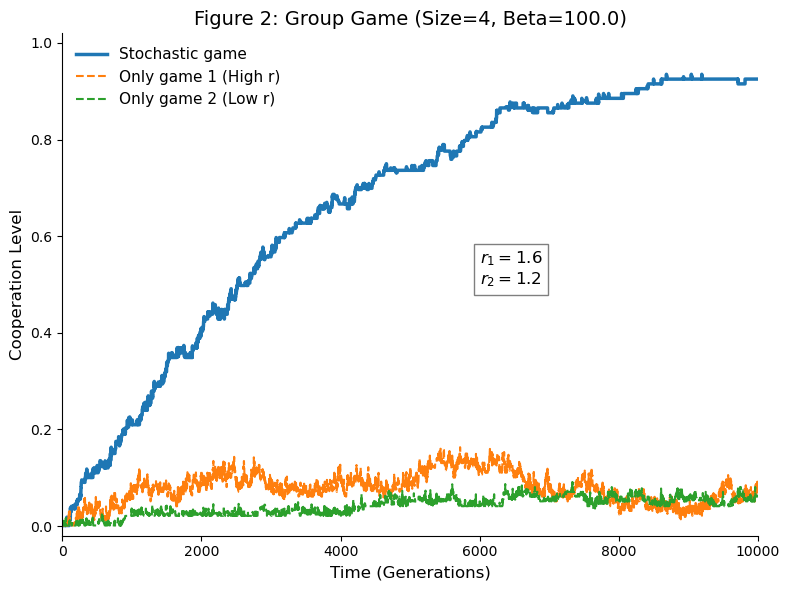

In [33]:
plt.figure(figsize=(8, 6))
x_group = np.arange(N_GEN_GROUP)

plt.plot(x_group, avg_s_gr, label='Stochastic game', linewidth=2.5)
plt.plot(x_group, avg_1_gr, label='Only game 1 (High r)', linestyle='--')
plt.plot(x_group, avg_2_gr, label='Only game 2 (Low r)', linestyle='--')

plt.ylim(-0.02, 1.02)
plt.xlim(0, N_GEN_GROUP)
plt.xlabel('Time (Generations)', fontsize=12)
plt.ylabel('Cooperation Level', fontsize=12)
plt.title(f'Figure 2: Group Game (Size={GR_SIZE}, Beta={BETA_GROUP})', fontsize=14)

# Plot aesthetics
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Annotate key parameters on the plot
plt.text(N_GEN_GROUP*0.6, 0.5, f"$r_1 = {R1_GROUP}$\n$r_2 = {R2_GROUP}$", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
print("Showing Plot 2.")
plt.show()